In [1]:
# Mount on Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# Install DeepRobust (from Lorenzo fork)

!pip install --upgrade texttable git+https://github.com/lorenzobasile/DeepRobust.git

  Cloning https://github.com/lorenzobasile/DeepRobust.git to /tmp/pip-req-build-jb5pfc88
  Running command git clone -q https://github.com/lorenzobasile/DeepRobust.git /tmp/pip-req-build-jb5pfc88
     |████████████████████████████████| 204kB 10.0MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
  Created wheel for deeprobust: filename=deeprobust-0-cp36-none-any.whl size=142494 sha256=c2043288fb9d5666d55d78708c76bb527c987fe30bc55efd072479af1229fa87
  Stored in directory: /tmp/pip-ephem-wheel-cache-7pm5qxsi/wheels/73/c5/ae/8043f3f08a70c4c2a4584449a4f97f415682a4f0371f8f3890
Successfully built deeprobust
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [3]:
!pip install advertorch

     |████████████████████████████████| 5.7MB 3.9MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp36-none-any.whl size=5696220 sha256=fd02424a60b3b815527da591dd188a5544b670697d09e3155bec022967396047
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch


In [4]:
# Going to my directory

%cd gdrive/My\ Drive/Colab Notebooks/projectsml

/content/gdrive/My Drive/Colab Notebooks/projectsml


In [ ]:
%ls -lhtr classes/

total 1.5K
-rw------- 1 root root 1.3K Jun 19 17:45 classes.txt


In [5]:
## LIBRARIES

## Usual python tools
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display

## Torch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Torchvision
import torchvision 

## DeepRobust
import deeprobust.image.netmodels.train_model as trainmodel
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.attack.fgsm import FGSM
from deeprobust.image.defense.fast import Fast
from deeprobust.image.defense.YOPO import YOPOpgd
from deeprobust.image.attack.onepixel import Onepixel
from deeprobust.image.config import attack_params
import deeprobust.image.netmodels.CNN as MODEL
from torchvision import transforms, datasets
from deeprobust.image.defense.fgsmtraining import FGSMtraining 
from deeprobust.image.defense.pgdtraining import PGDtraining
from deeprobust.image.config import defense_params
from deeprobust.image.netmodels.CNN import Net
import pandas as pd
from advertorch.attacks import SinglePixelAttack

In [6]:
torch.manual_seed(torch.rand(1))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


In [7]:
## SOME USEFUL FUNCTIONS

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.3, 0.3, 0.3])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, vmin=0, vmax=1)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)  # pause a bit so that plots are updated
    
    
def get_params_num(net):
    return sum(map(torch.numel, net.parameters()))

    
def get_accuracy(dataloader, model, device='cpu'):
    tot = len(dataloader.dataset)
    with torch.no_grad():
        n_right = 0
        for data in dataloader:
            batch = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(batch)
            out_labels = torch.argmax(outputs, dim=1)
            n_right += torch.sum(labels == out_labels)
           
    return float(n_right) / tot

In [15]:
## TRANSFORMATIONS

data_transforms = {'Training': torchvision.transforms.Compose([ torchvision.transforms.Resize((128,128)),
                                                                torchvision.transforms.ToTensor(),
                                                                torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3]) 
                                                              ]),
                   'Testing': torchvision.transforms.Compose([ torchvision.transforms.Resize((128,128)),
                                                                torchvision.transforms.ToTensor(),
                                                                torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3]) 
                                                              ])
                   }

/content/gdrive/My Drive/Colab Notebooks/projectsml


In [24]:
## LOADING DATA

# Location of data
data_dir = './animaletti/'

# Load dataset
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
# Create dataloaders (test and train)
dataloaders = {'Training': DataLoader(datasets['Training'], batch_size=64, shuffle=True),'Testing': DataLoader(datasets['Testing'], batch_size=64, shuffle=True)}

# Save sizes and classes
dataset_sizes = {x: len(datasets[x]) for x in ['Training', 'Testing']}

dicts={0:"cheetah",3:"tiger",1:"hyena",2:"jaguar"}

In [17]:
## PRINT SOME INFO ABOUT DATA

print(dataloaders['Training'].dataset)
print()
print(dataloaders['Testing'].dataset)

Dataset ImageFolder
    Number of datapoints: 3607
    Root location: ./animaletti/Training
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])
           )

Dataset ImageFolder
    Number of datapoints: 400
    Root location: ./animaletti/Testing
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])
           )


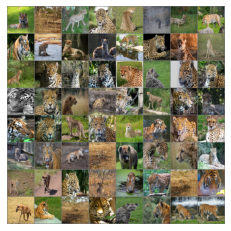

In [18]:
## PRINT SOME IMAGES

# Train
inputs, classes = next(iter(dataloaders['Training']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

# Test
inputs, classes = next(iter(dataloaders['Testing']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [14]:
%ls

animaletti/            animaletti_20e.h5  classes.txt  models@
animaletti_128_20e.h5  BelgiumTSC@        data/


In [19]:
## LOAD GOOGLENET

net=torchvision.models.googlenet(pretrained=True, progress=True)
net.fc=nn.Linear(net.fc.in_features,4)
net.to(device)
net.load_state_dict(torch.load("./animaletti_128_20e.h5"), strict=False)

<All keys matched successfully>

In [ ]:
# TRAINING GOOGLENET
net.to(device)
lr = 0.001
epochs = 20

n_batches = len(dataloaders['Training'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLhttps://medium.com/coinmonks/paper-review-of-googlenet-inception-v1-winner-of-ilsvlc-2014-image-classification-c2b3565a64e7R(optimizer=optimizer, gamma=0.99)

net.train() 
for e in range(epochs):
    for i, data in enumerate(dataloaders['Training']):
        batch = data[0].to(device)
        labels = data[1].to(device)      
        outputs = net(batch)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: {}".format(e, i, n_batches, loss.item()))
            display.clear_output(wait=True)
    scheduler.step()

In [20]:
## EVALUATE TEST ACCURACY

net.eval()
acc_test = get_accuracy(dataloaders['Testing'], net, device=device)
print("\nTest accuracy: {}".format(acc_test))


Test accuracy: 0.98


In [21]:
def _show_images(img, advimg, pred, advpred):
    
    perturb = advimg - img
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.3, 0.3, 0.3])

    plt.figure(figsize=(10, 8))

    plt.subplot(1, 3, 1)
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("original image\n prediction: {}".format(dicts[pred]))
    
    plt.subplot(1, 3, 2)
    perturb = perturb.numpy().transpose((1, 2, 0))
    perturb = std * perturb + mean
    perturb = np.clip(perturb, 0, 1)
    plt.imshow(perturb)
    plt.axis("off")
    plt.title("the perturbation")
    
    plt.subplot(1, 3, 3)
    advimg = advimg.numpy().transpose((1, 2, 0))
    advimg = std * advimg + mean
    advimg = np.clip(advimg, 0, 1)
    plt.imshow(advimg)
    plt.axis("off")
    plt.title("perturbed image\n prediction: {}".format(dicts[advpred]))
    plt.show()

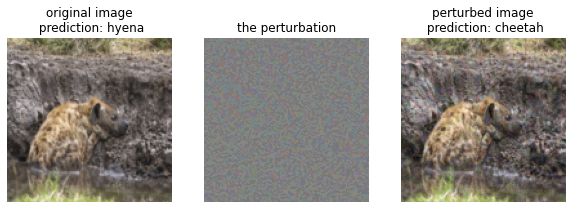

In [26]:
## FGSM Attack

x, y = next(iter(dataloaders['Testing']))
x = x.to('cuda').float()

adversary = FGSM(net, 'cuda')
Adv_img = adversary.generate(x, y, epsilon = 0.1)

output_adv = net(Adv_img)
output_img= net(x)


_show_images(img=x[0].cpu().detach(), advimg=Adv_img[0].cpu().detach(), 
             pred=torch.argmax(output_img, dim=1)[0].item(), advpred=torch.argmax(output_adv, dim=1)[0].item())

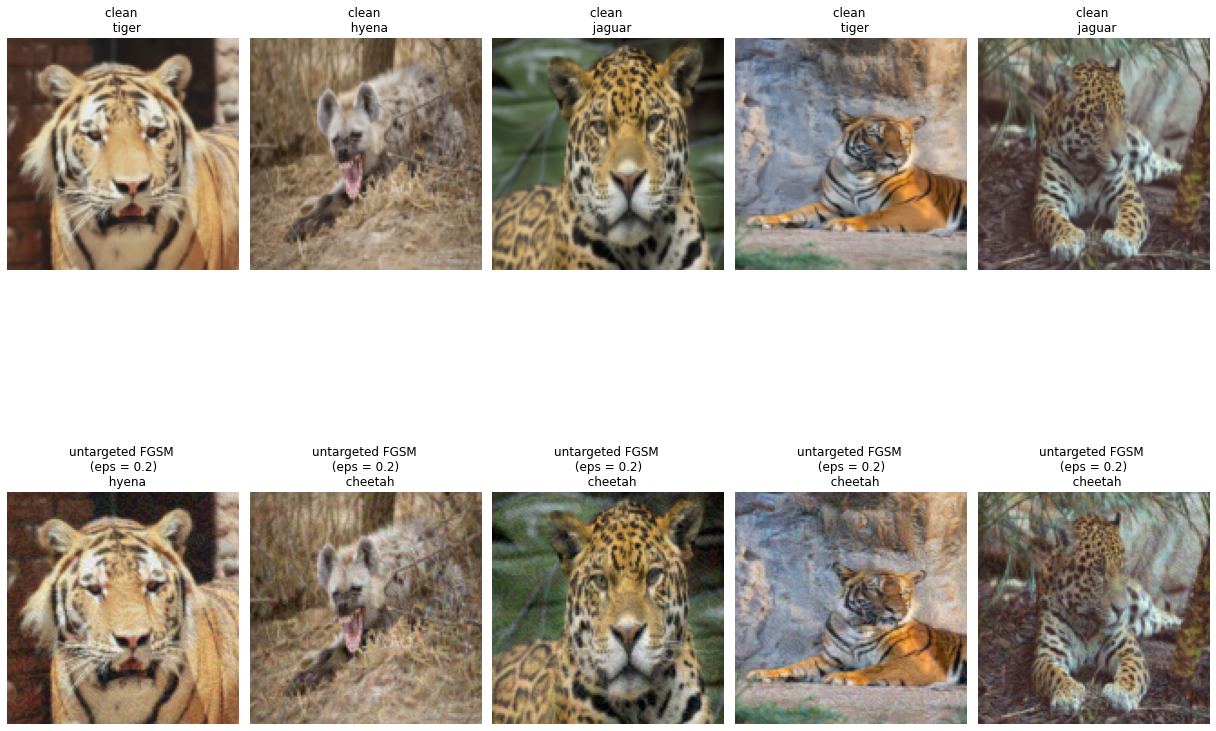

In [27]:
## SHOW IMAGES AND PREDICTION OF THE NET ON ADV. ATTACKS (EPSILON=0.2)

x, y = next(iter(dataloaders['Testing']))
x = x.to('cuda').float()

adversary = FGSM(net, 'cuda')
Adv_img = adversary.generate(x, y, epsilon = 0.1)

output_adv = net(Adv_img)
output_img = net(x)

pred=torch.argmax(output_img, dim=1)
advpred=torch.argmax(output_adv, dim=1)

plt.figure(figsize=(17,15))
batch_size = 5

for ii in range(5):
    plt.subplot(2, batch_size, ii + 1)
    imshow(x[ii].cpu().detach())
    plt.title("clean \n  {}".format(dicts[pred[ii].item()]))
    plt.subplot(2, batch_size, ii + 1 + batch_size)
    imshow(Adv_img[ii].cpu().detach())
    plt.title("untargeted FGSM \n (eps = {}) \n  {}".format(0.2, dicts[advpred[ii].item()]))

plt.tight_layout()
plt.show()

In [28]:
### ADVERSARIAL ACCURACY OF GOOGLENET 

epsilons = [0.3, 0.2, 0.15, 0.1, 0.05, 0.03, 0.01]
adversarial_accuracies_before = []

# Evaluate model on adversarial attacks
for eps in epsilons:
  
  correct = 0
  batch_number = 0
  tot = len(dataloaders['Testing'].dataset)
  
  for data, target in dataloaders['Testing']:
  
    #Send the data and label to the device
    data, target = data.to('cuda'), target.to('cuda')
    batch_size = data.size()[0]

    # Call FGSM Attack
    adversary = FGSM(net, 'cuda')
    Adv_img = adversary.generate(data, target, epsilon = eps)

    # Re-classify the perturbed image
    output = net(Adv_img)

    # Check for success
    final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability

    correct += torch.sum(target == final_pred)

  adversarial_accuracies_before.append(float(correct)/float(tot))
  print("Epsilon = {}: adversarial test Accuracy = {} / {} -> {:.2f}%".format(eps, correct, tot, float(correct)/float(tot)*100))

Epsilon = 0.3: adversarial test Accuracy = 75 / 400 -> 18.75%
Epsilon = 0.2: adversarial test Accuracy = 45 / 400 -> 11.25%
Epsilon = 0.15: adversarial test Accuracy = 34 / 400 -> 8.50%
Epsilon = 0.1: adversarial test Accuracy = 43 / 400 -> 10.75%
Epsilon = 0.05: adversarial test Accuracy = 97 / 400 -> 24.25%
Epsilon = 0.03: adversarial test Accuracy = 186 / 400 -> 46.50%
Epsilon = 0.01: adversarial test Accuracy = 337 / 400 -> 84.25%


In [ ]:
### ADVERSARIAL TRAINING (DON'T RUN ANYMORE!!)


for eps in epsilons:
    net.load_state_dict(torch.load("./animaletti_128_20e.h5"), strict=False)
    net.to(device)
    
    
    defense = FGSMtraining(net, device)
    defense.generate(train_loader=dataloaders['Training'], test_loader=dataloaders['Testing'], epsilon=eps, epoch_num= 20,
                    lr_train = 0.001, save_model = False)
    torch.save(net.state_dict(), "models/fgsm_128_animaletti_20e_eps%f.h5"%eps)

1
Train Epoch: 1 [0/3607 (0%)]	Loss: -3.438087	Accuracy:6.41%
Train Epoch: 1 [640/3607 (18%)]	Loss: -9.517482	Accuracy:71.09%
Train Epoch: 1 [1280/3607 (35%)]	Loss: -15.605757	Accuracy:82.34%
Train Epoch: 1 [1920/3607 (53%)]	Loss: -21.780075	Accuracy:80.00%
Train Epoch: 1 [2560/3607 (70%)]	Loss: -25.128107	Accuracy:73.12%
Train Epoch: 1 [3200/3607 (88%)]	Loss: -34.702255	Accuracy:82.03%

Test set: Clean loss: -40.812, Clean Accuracy: 375/400 (94%)


Test set: Adv loss: -27.410, Adv Accuracy: 211/400 (53%)

make new directory and save model in ./defense_models
2
Train Epoch: 2 [0/3607 (0%)]	Loss: -37.685616	Accuracy:8.28%
Train Epoch: 2 [640/3607 (18%)]	Loss: -47.222069	Accuracy:78.28%
Train Epoch: 2 [1280/3607 (35%)]	Loss: -51.317123	Accuracy:80.31%
Train Epoch: 2 [1920/3607 (53%)]	Loss: -58.233932	Accuracy:82.03%
Train Epoch: 2 [2560/3607 (70%)]	Loss: -65.523582	Accuracy:79.84%
Train Epoch: 2 [3200/3607 (88%)]	Loss: -67.697441	Accuracy:86.88%

Test set: Clean loss: -79.461, Clean Accu

In [ ]:
### ADVERSARIAL ACCURACY OF GOOGLENET AFTER ADVERSARIAL TRAINING

epsilons = [0.3, 0.2, 0.15, 0.1, 0.05, 0.03, 0.01]
adversarial_accuracies_after = []

# Evaluate model on adversarial attacks
for eps in epsilons:
  net.load_state_dict(torch.load('models/fgsm_64_20e_eps%f.h5'%eps), strict=False) 

  correct = 0
  batch_number = 0
  tot = len(dataloaders['Testing'].dataset)
  
  for data, target in dataloaders['Testing']:
  
    #Send the data and label to the device
    data, target = data.to('cuda'), target.to('cuda')
    batch_size = data.size()[0]


    # Call FGSM Attack
    adversary = FGSM(net, 'cuda')
    Adv_img = adversary.generate(data, target, epsilon = eps)

    # Re-classify the perturbed image
    output = net(Adv_img)

    # Check for success
    final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability

    correct += torch.sum(target == final_pred)

  adversarial_accuracies_after.append(float(correct)/float(tot))
  print("Epsilon = {}: adversarial test Accuracy = {} / {} -> {:.2f}%".format(eps, correct, tot, float(correct)/float(tot)*100))

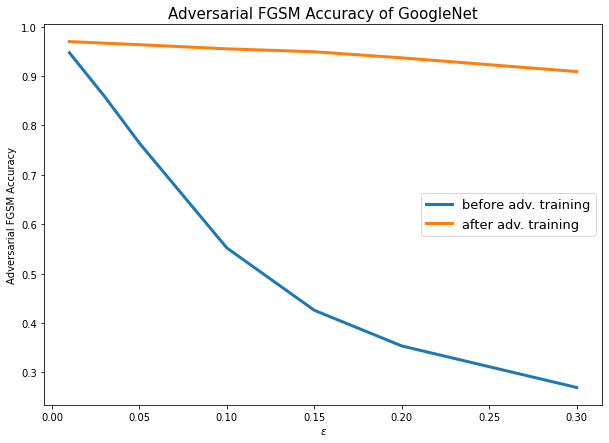

In [ ]:
## PLOT ACCURACIES BEFORE/AFTER ADVERSARIAL TRAINING

plt.figure(figsize=(10, 7))
epsilons = [0.3, 0.2, 0.15, 0.1, 0.05, 0.03, 0.01]

plt.plot(epsilons, adversarial_accuracies_before, lw=3, label='before adv. training')
plt.plot(epsilons, adversarial_accuracies_after, lw=3, label='after adv. training')
plt.title("Adversarial FGSM Accuracy of GoogleNet", fontsize=15)
plt.xlabel("$\epsilon$", fontsize=10)
plt.ylabel("Adversarial FGSM Accuracy", fontsize=10)
plt.legend(loc = 'center right', fontsize=13)
plt.savefig("plots/fgsm_attack.png")

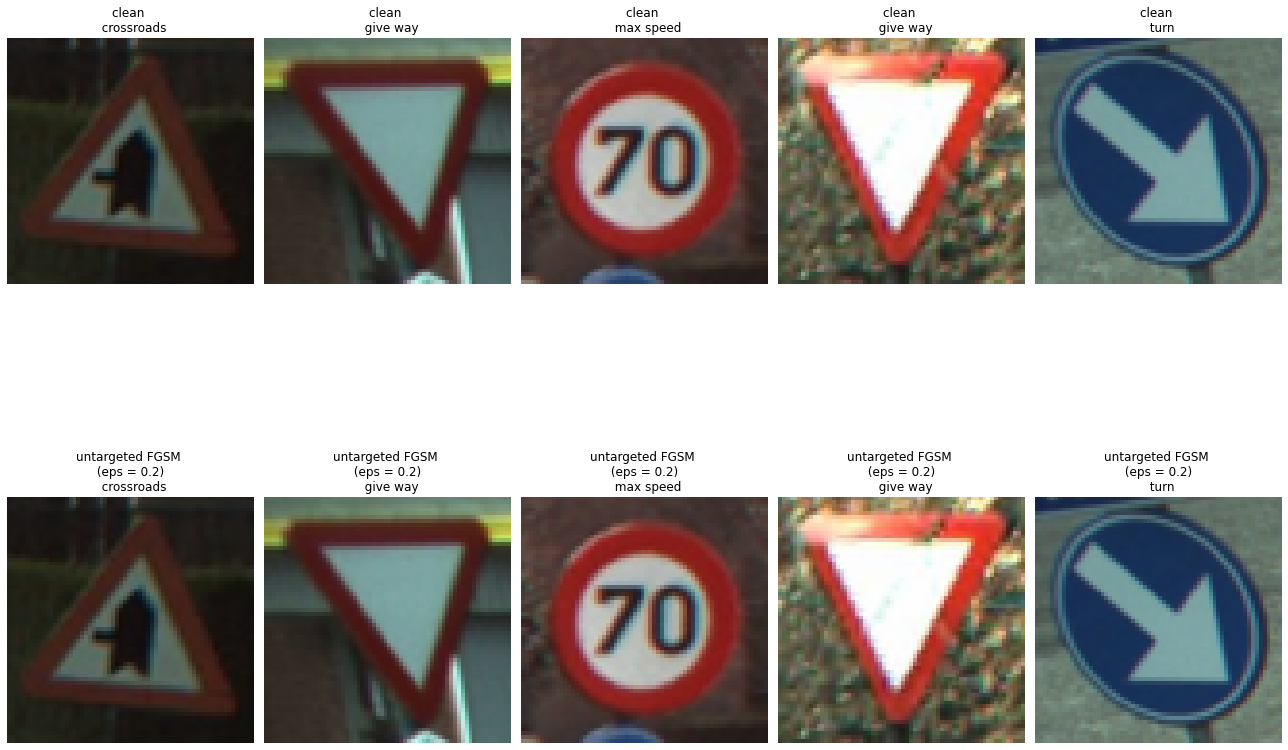

In [ ]:
## SHOW IMAGES AND PREDICTION OF THE NET ON ADV. ATTACKS (EPSILON=0.2)
## THE NET NOW HAS DONE ADV.TRAINING


net.load_state_dict(torch.load('models/fgsm_64_20e_eps%f.h5'%epsilons[1]), strict=False)


adversary = FGSM(net, 'cuda')
Adv_img = adversary.generate(x, y, epsilon = 0.2)

output_adv = net(Adv_img)
output_img = net(x)

pred=torch.argmax(output_img, dim=1)
advpred=torch.argmax(output_adv, dim=1)

plt.figure(figsize=(18,15))
batch_size = 5

for ii in range(5):
    plt.subplot(2, batch_size, ii + 1)
    imshow(x[ii].cpu().detach())
    plt.title("clean \n  {}".format(dicts[pred[ii].item()]))
    plt.subplot(2, batch_size, ii + 1 + batch_size)
    imshow(Adv_img[ii].cpu().detach())
    plt.title("untargeted FGSM \n (eps = {}) \n  {}".format(0.2, dicts[advpred[ii].item()]))

plt.tight_layout()
plt.show()